In [1]:
from ISLP import load_data
df = load_data("College")
df.columns

Index(['Private', 'Apps', 'Accept', 'Enroll', 'Top10perc', 'Top25perc',
       'F.Undergrad', 'P.Undergrad', 'Outstate', 'Room.Board', 'Books',
       'Personal', 'PhD', 'Terminal', 'S.F.Ratio', 'perc.alumni', 'Expend',
       'Grad.Rate'],
      dtype='object')

In [2]:
df["Private"] = df.Private.apply(lambda x: 1 if x=="Yes" else 0)
df["Accept.Rate"] = df["Accept"] / df["Apps"]
data = df.drop(columns=["Accept", "Apps"])

data

,Private,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate,Accept.Rate
0,1,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60,0.742169
1,1,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56,0.880146
2,1,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54,0.768207
3,1,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59,0.836930
4,1,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15,0.756477
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
772,0,543,4,26,3089,2029,6797,3900,500,1200,60,60,21.0,14,4469,40,0.689577
773,1,695,24,47,2849,1107,11520,4960,600,1250,73,75,13.3,31,9189,83,0.921388
774,1,695,34,61,2793,166,6900,4200,617,781,67,75,14.4,20,8323,49,0.913209
775,1,1317,95,99,5217,83,19840,6510,630,2115,96,96,5.8,49,40386,99,0.229145


In [3]:
X_cols = ['Private', 'Enroll', 'Top10perc', 'Top25perc', 'F.Undergrad',
          'P.Undergrad', 'Outstate', 'Room.Board', 'Books', 'Personal', 'PhD',
          'Terminal', 'S.F.Ratio', 'perc.alumni', 'Expend', 'Grad.Rate']

In [4]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data[X_cols], data["Accept.Rate"], test_size=0.2, random_state=42, shuffle=True)

In [5]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=5, min_samples_split=19, min_samples_leaf=4, n_estimators=3, learning_rate=1.0)
gbrt.fit(x_train, y_train)

GradientBoostingRegressor(learning_rate=1.0, max_depth=5, min_samples_leaf=4,
                          min_samples_split=19, n_estimators=3)

In [6]:
from sklearn.tree import export_graphviz

export_graphviz(gbrt.estimators_[2][0], out_file="graph.dot", feature_names=X_cols, rounded=True, filled=True)

In [7]:
!dot -Tpng graph.dot -o randomTrees/tree2.png

In [8]:
from sklearn.metrics import mean_squared_error

print(f"Test error for Accept.Rate is {mean_squared_error(y_test, gbrt.predict(x_test))}")

Test error for Accept.Rate is 0.019381650732775528


In [9]:
# Friedman_MSE for picking potential splits in regression tree
# Improvement = MSE(N)−((N_L)(MSE(N_L)/N) + (N_R)(MSE(N_R)/N))
# Friedman_MSE = Improvement/(MSE(N_L) + MSE(N_R))

In [10]:
from sklearn.model_selection import GridSearchCV

def staged_scorer(gbr, X, y_true):
    best_score = float('inf')

    for stage, y_pred in enumerate(gbr.staged_predict(X)):
        score = mean_squared_error(y_true, y_pred)
        if score < best_score:
            best_score = score

    return -best_score

param_grid = {
    'n_estimators': list(range(1, 400)),
    'max_depth': list(range(1, 10)),
    'min_samples_split': list(range(1, 10))
}

# GridSearch with custom scorer
grid_search = GridSearchCV(GradientBoostingRegressor(), param_grid, scoring=staged_scorer, cv=3)
grid_search.fit(x_train, y_train)

# Results
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Score: {-grid_search.best_score_}")

Best Parameters: {'max_depth': 3, 'min_samples_split': 7, 'n_estimators': 64}
Best Score: 0.011495823685610009


/Users/jay/opt/anaconda3/envs/ml_a1/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
810 fits failed out of a total of 7290.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
810 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/jay/opt/anaconda3/envs/ml_a1/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jay/opt/anaconda3/envs/ml_a1/lib/python3.10/site-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/Users/jay/opt/anaconda3/envs/ml_a1/lib/python3.10/site-packages/sklearn/base.py", line 638, in _validate_pa

In [13]:
feature_importances_regressor = grid_search.best_estimator_.feature_importances_

In [15]:
import numpy as np
import pandas as pd
sorted_indices_regressor = np.argsort(feature_importances_regressor)[::-1]
sorted_importances_regressor = feature_importances_regressor[sorted_indices_regressor]
sorted_feature_names_regressor = np.array(X_cols)[sorted_indices_regressor]

# Creating a DataFrame for better visualization
feature_importance_df_regressor = pd.DataFrame({
    'Feature': sorted_feature_names_regressor,
    'Importance': sorted_importances_regressor
})


In [16]:
feature_importance_df_regressor

,Feature,Importance
0,Top25perc,0.232730
1,Grad.Rate,0.171670
2,Top10perc,0.166890
3,Outstate,0.117063
4,F.Undergrad,0.071602
5,Room.Board,0.065065
6,Books,0.046812
7,Terminal,0.021210
8,Expend,0.020525
9,Enroll,0.017492


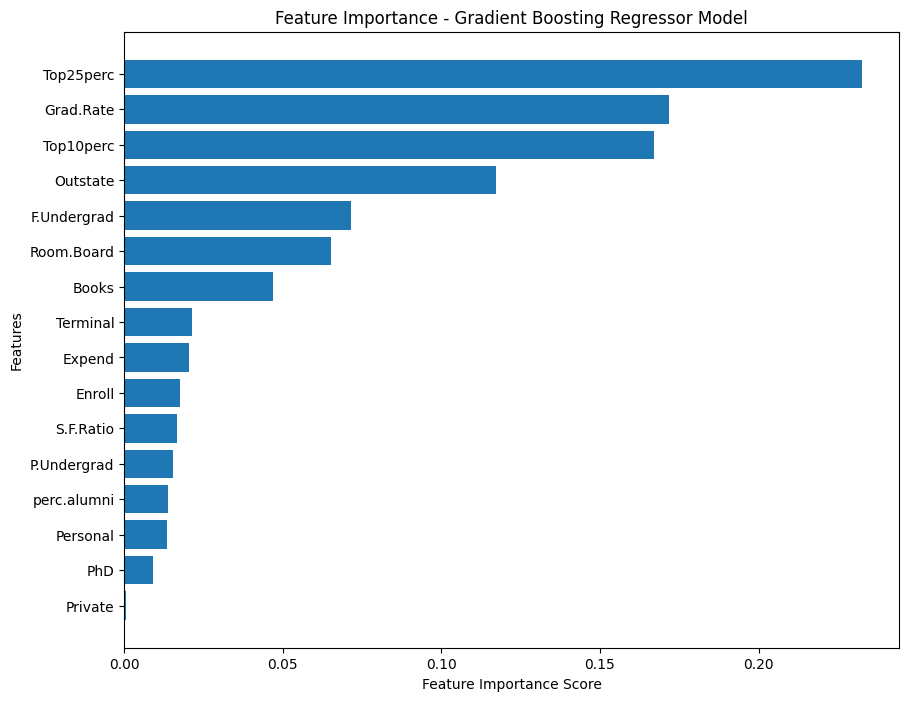

In [18]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
plt.barh(range(len(X_cols)), feature_importance_df_regressor['Importance'], align='center')
plt.yticks(range(len(X_cols)), feature_importance_df_regressor['Feature'])
plt.gca().invert_yaxis()  # Invert y-axis to have the feature with the highest importance at the top
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('Feature Importance - Gradient Boosting Regressor Model')
plt.show()

# These importance scores suggest that academic performance metrics (like Top25perc, Grad.Rate, and Top10perc) and financial aspects (like Outstate and Room.Board) are significant predictors in the model.
Top25perc (0.232730): This feature has the highest importance score, indicating that it is the most influential in predicting the model's outcome.
Grad.Rate (0.171670): The graduation rate is the second most important feature, which is quite intuitive as it's likely a key indicator of a college's success or the academic level of its students.
